In [24]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import numpy as np

import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import h2o
from h2o.automl import H2OAutoML

In [10]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21); OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from /opt/miniconda3/envs/ml/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/7c/4zd9z5fj2hq4vc0mmsq8wwlc0000gn/T/tmp1kl2h5ag
  JVM stdout: /var/folders/7c/4zd9z5fj2hq4vc0mmsq8wwlc0000gn/T/tmp1kl2h5ag/h2o_karanjogi_started_from_python.out
  JVM stderr: /var/folders/7c/4zd9z5fj2hq4vc0mmsq8wwlc0000gn/T/tmp1kl2h5ag/h2o_karanjogi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,1 month and 7 days
H2O_cluster_name:,H2O_from_python_karanjogi_3xd3e9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/karanjogi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
df=pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true',
               compression='zip',
               sep=',',
               quotechar='"')

In [13]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704


In [14]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

<AxesSubplot:>

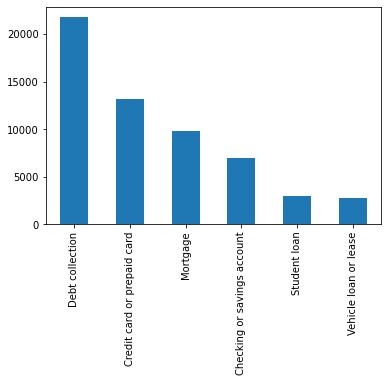

In [15]:
df['Product'].value_counts().plot(kind='bar')

In [16]:
df['Company'].value_counts()

CITIBANK, N.A.                                                    3226
CAPITAL ONE FINANCIAL CORPORATION                                 2711
BANK OF AMERICA, NATIONAL ASSOCIATION                             2580
JPMORGAN CHASE & CO.                                              2409
WELLS FARGO & COMPANY                                             2001
                                                                  ... 
Time Investment Company, Inc.                                        1
Automotive Services Finance, Inc.                                    1
Foxstar Energy Resources LLC DBA Federal Student Loans Council       1
Uplift, Inc                                                          1
Keystone Credit Services LLC                                         1
Name: Company, Length: 2197, dtype: int64

In [18]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [19]:
complaints_df = df[['Consumer complaint narrative', 'Product', 'Company']].rename(columns={'Consumer complaint narrative': 'complaints',
                                                                                           'Product':'product',
                                                                                           'Company': 'company'})

In [34]:
pd.set_option('display.max_colwidth', -1)
complaints_df


/var/folders/7c/4zd9z5fj2hq4vc0mmsq8wwlc0000gn/T/ipykernel_20947/4204658510.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,complaints,product,company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

In [36]:
target={'Debt collection':0, 'Credit card or prepaid card':1, 'Mortgage':2, 'Checking or savings account':3, 'Student loan':4, 'Vehicle loan or lease':5}
complaints_df['target']=complaints_df['product'].map(target)
complaints_df

,complaints,product,company,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked

In [38]:
X_train, X_test = train_test_split(complaints_df, test_size=0.2, random_state=4, stratify=complaints_df['target'])

In [40]:
stemmer = SnowballStemmer('english')

In [41]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karanjogi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
def tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
    tokens = map(str.lower, tokens)
    stems = [stemmer.stem(token) for token in tokens if (token not in stop_words)]
    return stems


In [44]:
vectorize_tf = TfidfVectorizer(tokenizer=tokenize,
                               stop_words=None,
                               max_df = 0.75,
                               max_features=1000,
                               lowercase=False,
                               ngram_range=(1, 2))

train_vectors = vectorize_tf.fit_transform(X_train.complaints)

In [45]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.13400997,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [46]:
vectorize_tf.get_feature_names()

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'assess',
 'assign',
 'assist',
 'associ',
 'assu

In [47]:
X_train.shape

(45962, 4)

In [51]:
train_df = pd.DataFrame(train_vectors.toarray(), columns = vectorize_tf.get_feature_names_out())
train_df = pd.concat([train_df, X_train['target'].reset_index(drop=True)], axis=1)
train_df

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,...,would need,would receiv,would take,write,written,wrong,wrote,year,yesterday,target
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.062616,0.0,0.0,0.046701,0.048684,0.0,0.000000,0.000000,0.0,0
2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0
3,0.0,0.000000,0.000000,0.0,0.073699,0.0,0.0,0.062016,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.049832,0.0,1
4,0.0,0.038345,0.059467,0.0,0.000000,0.0,0.0,0.192185,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45957,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.058621,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.174107,0.000000,0.0,0
45958,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.124328,0.000000,0.0,0.000000,0.000000,0.0,2
45959,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.134010,0.0,0
45960,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.095967,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,3


In [54]:
test_vectors = vectorize_tf.transform(X_test.complaints)
test_df = pd.DataFrame(test_vectors.toarray(), columns=vectorize_tf.get_feature_names_out())
test_df = pd.concat([test_df, X_test['target'].reset_index(drop=True)], axis=1)
test_df

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,...,would need,would receiv,would take,write,written,wrong,wrote,year,yesterday,target
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0
1,0.0,0.050682,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0
2,0.0,0.311955,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.251264,0.0,4
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.293618,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.022424,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.036037,0.0,0
11487,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.099134,0.0,0.0,...,0.0,0.0,0.0,0.0,0.243577,0.0,0.0,0.000000,0.0,0
11488,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0
11489,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,2


In [56]:
h2o_train = h2o.H2OFrame(train_df)
h2o_test = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [57]:
h2o_train.types

{'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account bank': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account inform': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'act': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advantag': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'real',
 'alert': 'real',
 'alleg': 'real',
 'alleg debt': 'real',
 'alli': 'real',
 'allow': 'real',
 'almost': 'real'

In [58]:
h2o_train['target'] = h2o_train['target'].asfactor()
h2o_test['target'] = h2o_test['target'].asfactor()

In [65]:
aml = H2OAutoML(max_models = 14, seed = 10, exclude_algos = ["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)

In [66]:
x=vectorize_tf.get_feature_names_out().tolist()
y='target'

In [67]:
aml.train(x=x,
          y=y,
          training_frame=h2o_train,
          validation_frame=h2o_test
         )

AutoML progress: |
19:16:08.395: Project: AutoML_2_20220324_191608
19:16:08.396: Cross-validation disabled by user: no fold column nor nfolds > 1.
19:16:08.396: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
19:16:08.396: Build control seed: 10
19:16:08.401: training frame: Frame key: AutoML_2_20220324_191608_training_py_1_sid_b473    cols: 1001    rows: 45962  chunks: 53    size: 38402832  checksum: 8172860180471695878
19:16:08.402: validation frame: Frame key: py_2_sid_b473    cols: 1001    rows: 11491  chunks: 14    size: 9543041  checksum: -6024289212680847839
19:16:08.402: leaderboard frame: Frame key: py_2_sid_b473    cols: 1001    rows: 11491  chunks: 14    size: 9543041  checksum: -6024289212680847839
19:16:08.403: blending frame: NULL
19:16:08.403: response column: target
19:16:08.403: fold column: null
19:16:08.403: weights column: null
19:16:08.404: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w)

,,number_of_trees
0,,130.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.02591136940313337
RMSE: 0.1609700885355207
LogLoss: 0.09998733886189735
Mean Per-Class Error: 0.030323814151202878
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,17205.0,119.0,39.0,30.0,13.0,12.0,0.012229,"213 / 17,418"
1,182.0,10294.0,9.0,59.0,6.0,4.0,0.024635,"260 / 10,554"
2,51.0,44.0,7729.0,9.0,4.0,2.0,0.014032,"110 / 7,839"
3,58.0,56.0,7.0,5480.0,0.0,1.0,0.021778,"122 / 5,602"
4,41.0,46.0,6.0,1.0,2266.0,0.0,0.039831,"94 / 2,360"
5,74.0,64.0,5.0,4.0,5.0,2037.0,0.069438,"152 / 2,189"
6,17611.0,10623.0,7795.0,5583.0,2294.0,2056.0,0.020691,"951 / 45,962"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.979309
1,2,0.995039
2,3,0.998347
3,4,0.999478
4,5,0.999913
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09544108086953851
RMSE: 0.3089353991849081
LogLoss: 0.3329299954232969
Mean Per-Class Error: 0.15281871230856267
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,4041.0,150.0,51.0,28.0,52.0,32.0,0.071888,"313 / 4,354"
1,165.0,2323.0,20.0,116.0,2.0,13.0,0.119742,"316 / 2,639"
2,60.0,36.0,1813.0,21.0,7.0,23.0,0.075000,"147 / 1,960"
3,39.0,142.0,13.0,1195.0,4.0,8.0,0.147038,"206 / 1,401"
4,58.0,16.0,17.0,2.0,484.0,13.0,0.179661,106 / 590
5,91.0,45.0,29.0,7.0,5.0,370.0,0.323583,177 / 547
6,4454.0,2712.0,1943.0,1369.0,554.0,459.0,0.110086,"1,265 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.889914
1,2,0.963885
2,3,0.984510
3,4,0.993560
4,5,0.998521
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2022-03-24 19:27:05,0.016 sec,0.0,0.833333,1.791759,0.829446,NaN,NaN,0.833333,1.791759,0.829432,NaN,NaN
1,,2022-03-24 19:27:21,15.947 sec,5.0,0.455920,0.626220,0.119816,NaN,NaN,0.473835,0.668809,0.146811,NaN,NaN
2,,2022-03-24 19:27:35,29.874 sec,10.0,0.348954,0.401917,0.102171,NaN,NaN,0.383419,0.474257,0.136107,NaN,NaN
3,,2022-03-24 19:27:48,43.525 sec,15.0,0.308416,0.317346,0.088595,NaN,NaN,0.355018,0.411529,0.129841,NaN,NaN
4,,2022-03-24 19:28:02,57.186 sec,20.0,0.286344,0.274151,0.079326,NaN,NaN,0.341246,0.382958,0.125141,NaN,NaN
5,,2022-03-24 19:28:16,1 min 10.616 sec,25.0,0.271568,0.247436,0.071733,NaN,NaN,0.333986,0.368864,0.122270,NaN,NaN
6,,2022-03-24 19:28:29,1 min 23.942 sec,30.0,0.259910,0.227697,0.066272,NaN,NaN,0.328798,0.359313,0.119920,NaN,NaN
7,,2022-03-24 19:28:42,1 min 36.964 sec,35.0,0.250900,0.213228,0.061573,NaN,NaN,0.325547,0.353832,0.119224,NaN,NaN
8,,2022-03-24 19:28:54,1 min 49.185 sec,40.0,0.243236,0.201438,0.057591,NaN,NaN,0.323265,0.350062,0.118179,NaN,NaN
9,,2022-03-24 19:29:07,2 min 1.728 sec,45.0,0.234771,0.188890,0.053196,NaN,NaN,0.320830,0.345704,0.115656,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,mortgag,18577.900391,1.000000,0.108526
1,debt,16022.158203,0.862431,0.093596
2,card,13522.264648,0.727868,0.078993
3,loan,9963.533203,0.536311,0.058204
4,bank,7403.456055,0.398509,0.043249
5,collect,6349.020996,0.341751,0.037089
6,payment,4439.176758,0.238949,0.025932
7,credit card,3263.979492,0.175692,0.019067
8,account,3046.769775,0.164000,0.017798
9,credit,2803.204590,0.150889,0.016375



See the whole table with table.as_data_frame()


In [68]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_2_AutoML_2_20220324_191608,0.152819,0.33293,0.308935,0.0954411
XGBoost_1_AutoML_2_20220324_191608,0.155238,0.334303,0.311769,0.0971999
XGBoost_grid_1_AutoML_2_20220324_191608_model_1,0.156073,0.33344,0.312922,0.0979204
GBM_1_AutoML_2_20220324_191608,0.156564,0.374714,0.328888,0.108168
XGBoost_3_AutoML_2_20220324_191608,0.16093,0.335324,0.315729,0.0996848
GBM_4_AutoML_2_20220324_191608,0.16198,0.399907,0.338448,0.114547
GBM_2_AutoML_2_20220324_191608,0.164147,0.391543,0.340189,0.115728
GBM_3_AutoML_2_20220324_191608,0.165691,0.393175,0.339797,0.115462
GBM_5_AutoML_2_20220324_191608,0.167876,0.403019,0.345767,0.119555
GBM_grid_1_AutoML_2_20220324_191608_model_1,0.170788,0.386984,0.342348,0.117202


In [70]:
pred = aml.leader.predict(h2o_test)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [71]:
aml.leader.model_performance(h2o_test)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.09544108086953851
RMSE: 0.3089353991849081
LogLoss: 0.3329299954232969
Mean Per-Class Error: 0.15281871230856267
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,4041.0,150.0,51.0,28.0,52.0,32.0,0.071888,"313 / 4,354"
1,165.0,2323.0,20.0,116.0,2.0,13.0,0.119742,"316 / 2,639"
2,60.0,36.0,1813.0,21.0,7.0,23.0,0.075000,"147 / 1,960"
3,39.0,142.0,13.0,1195.0,4.0,8.0,0.147038,"206 / 1,401"
4,58.0,16.0,17.0,2.0,484.0,13.0,0.179661,106 / 590
5,91.0,45.0,29.0,7.0,5.0,370.0,0.323583,177 / 547
6,4454.0,2712.0,1943.0,1369.0,554.0,459.0,0.110086,"1,265 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.889914
1,2,0.963885
2,3,0.984510
3,4,0.993560
4,5,0.998521
5,6,1.000000


In [76]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [78]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_2_20220324_191608


Model Summary: 


,,number_of_trees
0,,130.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.02591136940313337
RMSE: 0.1609700885355207
LogLoss: 0.09998733886189735
Mean Per-Class Error: 0.030323814151202878
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,17205.0,119.0,39.0,30.0,13.0,12.0,0.012229,"213 / 17,418"
1,182.0,10294.0,9.0,59.0,6.0,4.0,0.024635,"260 / 10,554"
2,51.0,44.0,7729.0,9.0,4.0,2.0,0.014032,"110 / 7,839"
3,58.0,56.0,7.0,5480.0,0.0,1.0,0.021778,"122 / 5,602"
4,41.0,46.0,6.0,1.0,2266.0,0.0,0.039831,"94 / 2,360"
5,74.0,64.0,5.0,4.0,5.0,2037.0,0.069438,"152 / 2,189"
6,17611.0,10623.0,7795.0,5583.0,2294.0,2056.0,0.020691,"951 / 45,962"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.979309
1,2,0.995039
2,3,0.998347
3,4,0.999478
4,5,0.999913
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09544108086953851
RMSE: 0.3089353991849081
LogLoss: 0.3329299954232969
Mean Per-Class Error: 0.15281871230856267
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,4041.0,150.0,51.0,28.0,52.0,32.0,0.071888,"313 / 4,354"
1,165.0,2323.0,20.0,116.0,2.0,13.0,0.119742,"316 / 2,639"
2,60.0,36.0,1813.0,21.0,7.0,23.0,0.075000,"147 / 1,960"
3,39.0,142.0,13.0,1195.0,4.0,8.0,0.147038,"206 / 1,401"
4,58.0,16.0,17.0,2.0,484.0,13.0,0.179661,106 / 590
5,91.0,45.0,29.0,7.0,5.0,370.0,0.323583,177 / 547
6,4454.0,2712.0,1943.0,1369.0,554.0,459.0,0.110086,"1,265 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.889914
1,2,0.963885
2,3,0.984510
3,4,0.993560
4,5,0.998521
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2022-03-24 19:27:05,0.016 sec,0.0,0.833333,1.791759,0.829446,NaN,NaN,0.833333,1.791759,0.829432,NaN,NaN
1,,2022-03-24 19:27:21,15.947 sec,5.0,0.455920,0.626220,0.119816,NaN,NaN,0.473835,0.668809,0.146811,NaN,NaN
2,,2022-03-24 19:27:35,29.874 sec,10.0,0.348954,0.401917,0.102171,NaN,NaN,0.383419,0.474257,0.136107,NaN,NaN
3,,2022-03-24 19:27:48,43.525 sec,15.0,0.308416,0.317346,0.088595,NaN,NaN,0.355018,0.411529,0.129841,NaN,NaN
4,,2022-03-24 19:28:02,57.186 sec,20.0,0.286344,0.274151,0.079326,NaN,NaN,0.341246,0.382958,0.125141,NaN,NaN
5,,2022-03-24 19:28:16,1 min 10.616 sec,25.0,0.271568,0.247436,0.071733,NaN,NaN,0.333986,0.368864,0.122270,NaN,NaN
6,,2022-03-24 19:28:29,1 min 23.942 sec,30.0,0.259910,0.227697,0.066272,NaN,NaN,0.328798,0.359313,0.119920,NaN,NaN
7,,2022-03-24 19:28:42,1 min 36.964 sec,35.0,0.250900,0.213228,0.061573,NaN,NaN,0.325547,0.353832,0.119224,NaN,NaN
8,,2022-03-24 19:28:54,1 min 49.185 sec,40.0,0.243236,0.201438,0.057591,NaN,NaN,0.323265,0.350062,0.118179,NaN,NaN
9,,2022-03-24 19:29:07,2 min 1.728 sec,45.0,0.234771,0.188890,0.053196,NaN,NaN,0.320830,0.345704,0.115656,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,mortgag,18577.900391,1.000000,0.108526
1,debt,16022.158203,0.862431,0.093596
2,card,13522.264648,0.727868,0.078993
3,loan,9963.533203,0.536311,0.058204
4,bank,7403.456055,0.398509,0.043249
5,collect,6349.020996,0.341751,0.037089
6,payment,4439.176758,0.238949,0.025932
7,credit card,3263.979492,0.175692,0.019067
8,account,3046.769775,0.164000,0.017798
9,credit,2803.204590,0.150889,0.016375



See the whole table with table.as_data_frame()


In [81]:
import xgboost as xgb
out.convert_H2OXGBoostParams_2_XGBoostParams()

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


({'silent': True,
  'eta': 0.3,
  'colsample_bylevel': 0.8,
  'objective': 'multi:softprob',
  'min_child_weight': 5.0,
  'nthread': 8,
  'seed': 13,
  'num_class': 6,
  'max_depth': 10,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 10000,
  'subsample': 0.6,
  'max_delta_step': 0.0,
  'tree_method': 'exact'},
 10000)

In [82]:
from sklearn.metrics import classification_report, confusion_matrix

In [86]:
xgb_clf = xgb.XGBClassifier(n_estimators=100,
                            learning_rate=0.05,
                            max_depth=6,
                            objective='multi:softprob',
                            random_state=10         
                           )

In [87]:
xgb_clf.fit(train_vectors, X_train['target'])

[21:42:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [89]:
predictions = xgb_clf.predict(test_vectors)

In [90]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3978  183   62   38   53   40]
 [ 259 2243   11  117    1    8]
 [ 105   41 1777   20    8    9]
 [  97  142   17 1134    4    7]
 [  90   23   17    2  452    6]
 [ 116   62   28   10    3  328]]


In [93]:
print('classification report : \n', classification_report(X_test['target'], predictions))

classification report : 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      4354
           1       0.83      0.85      0.84      2639
           2       0.93      0.91      0.92      1960
           3       0.86      0.81      0.83      1401
           4       0.87      0.77      0.81       590
           5       0.82      0.60      0.69       547

    accuracy                           0.86     11491
   macro avg       0.86      0.81      0.83     11491
weighted avg       0.86      0.86      0.86     11491



In [96]:
from sklearn.utils import class_weight

class_weights = list(class_weight.compute_class_weight(class_weight='balanced',
                                                       classes=np.unique(X_train['target']),
                                                       y=X_train['target']))

In [97]:
class_weights

[0.439794082749646,
 0.7258227528267324,
 0.9772079772079773,
 1.367428299416875,
 3.2459039548022597,
 3.4994670321303487]

In [98]:
weights = np.ones(X_train.shape[0], dtype = 'float')

In [99]:
for i, val in enumerate(X_train['target']):
    weights[i] = class_weights[val]

In [100]:
weights

array([0.43979408, 0.43979408, 0.43979408, ..., 0.43979408, 1.3674283 ,
       0.72582275])

In [101]:
xgb_clf = xgb_clf = xgb.XGBClassifier(n_estimators=100,
                            learning_rate=0.05,
                            max_depth=6,
                            objective='multi:softprob',
                            random_state=10         
                           )

In [102]:
xgb_clf.fit(train_vectors, X_train['target'], sample_weight=weights)

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:52:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [103]:
predictions = xgb_clf.predict(test_vectors)
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3722  212   69  105   92  154]
 [ 153 2177   12  192    4  101]
 [  39   21 1754   27   43   76]
 [  39  105   11 1217   10   19]
 [  34    4    2    2  506   42]
 [  42   19    8   18   26  434]]


In [104]:
print('classification report : \n', classification_report(X_test['target'], predictions))

classification report : 
               precision    recall  f1-score   support

           0       0.92      0.85      0.89      4354
           1       0.86      0.82      0.84      2639
           2       0.95      0.89      0.92      1960
           3       0.78      0.87      0.82      1401
           4       0.74      0.86      0.80       590
           5       0.53      0.79      0.63       547

    accuracy                           0.85     11491
   macro avg       0.80      0.85      0.82     11491
weighted avg       0.87      0.85      0.86     11491

